In [63]:
# !pip install torch
# !pip install pandas
# !pip install torchvision
# !pip install albumentations
# !pip install tqdm
# !pip install scikit-learn
# !pip install imageio
# !pip install matplotlib

In [64]:
import torch
import pandas as pd
import torchvision
import albumentations as A
from tqdm.auto import tqdm
from typing import Callable
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch import nn
import imageio.v3 as iio
# from PIL import Image
from pathlib import Path

# Leaf-traits ResNet test

## Transform-normalize data

In [65]:
train_image_bytes = pd.read_csv("../data/02_intermediate/train_image_bytes.csv")

In [66]:
class Config():
    ORIGINAL_IMAGE_SIZE = 512
    IMAGE_SIZE = 288
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 8
    BATCH_SIZE_VAL = 16
    N_VAL_SAMPLES = 4096
    LR_MAX = 3e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 12
    TRAIN_MODEL = True
    SEED = 42
    EPS = 1e-6
    EPS_CUDA = torch.tensor([EPS]).to('cuda')
    FEATURES = train_image_bytes.columns.tolist()[2:-14]
    N_FEATURES = len(FEATURES)

CONFIG = Config()

In [67]:
train, val = train_test_split(train_image_bytes, )
CONFIG.TARGET_MEDIANS = train[CONFIG.TARGET_COLUMNS].median(axis=0).values

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [127]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

In [69]:
from torch.utils.data import Dataset, DataLoader
import imageio.v3 as iio
from pathlib import Path
import numpy as np


# Datasets
class MyDataset(Dataset):
    def __init__(
        self, 
        file_path: np.ndarray, 
        targets: np.ndarray, 
        features: np.ndarray, 
        transforms: A.Compose = None       
	):
        self.file_path = file_path
        self.targets = targets
        self.features = features
        self.transforms = transforms

    def __len__(self):
        return len(self.file_path)

    def __getitem__(self, index):
        X_sample = {
            'image': self.transforms(
                    image=iio.imread(Path("..", self.file_path[index])),
                )['image'],
            'feature': self.features[index],
        }
        y_sample = self.targets[index]
            
        return X_sample, y_sample



In [70]:
# Add augmentations
TRAIN_TRANSFORMS = A.Compose([
        A.RandomSizedCrop(
            [int(0.85*CONFIG.ORIGINAL_IMAGE_SIZE), CONFIG.ORIGINAL_IMAGE_SIZE],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=1.0
        ),
        A.HorizontalFlip(p=0.50),
        A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
        A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
        ToTensorV2(),
    ])

VAL_TEST_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE,CONFIG.IMAGE_SIZE),
        ToTensorV2(),
    ])

In [71]:
train_dataset = MyDataset(
    train['file_path'].values,
    train[CONFIG.TARGET_COLUMNS].to_numpy(),
    train[CONFIG.FEATURES].to_numpy(),
    TRAIN_TRANSFORMS,
)

val_dataset = MyDataset(
    val['file_path'].values,
    val[CONFIG.TARGET_COLUMNS].to_numpy(),
    val[CONFIG.FEATURES].to_numpy(),
    VAL_TEST_TRANSFORMS,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        drop_last=True,
        num_workers=1,
    )

val_dataloader = DataLoader(
    val_dataset,
    batch_size=CONFIG.BATCH_SIZE_VAL,
    drop_last=True,
    num_workers=1
)

In [72]:
train.columns

Index(['Unnamed: 0', 'id', 'WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg',
       ...
       'X50_mean', 'X3112_mean', 'X4_sd', 'X11_sd', 'X18_sd', 'X26_sd',
       'X50_sd', 'X3112_sd', 'file_path', 'jpeg_bytes'],
      dtype='object', length=179)

In [73]:
example_image_path = train['file_path'].iloc[0]

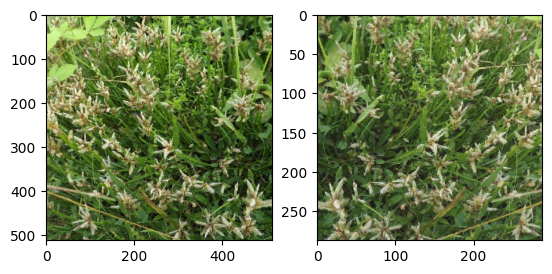

In [74]:
# Visualize transformations

image_array = iio.imread(Path("..", example_image_path))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image_array)
axs[1].imshow(TRAIN_TRANSFORMS(image=image_array)['image'].permute(1,2,0))

## Models

In [75]:
pretrained_resnet_weights = torchvision.models.ResNet50_Weights.DEFAULT
pretrained_resnet = torchvision.models.resnet50(weights=pretrained_resnet_weights).to(device)

In [76]:
for parameter in pretrained_resnet.parameters():
    parameter.requires_grad = False

In [77]:
pretrained_resnet.fc = nn.Linear(in_features = 2048, out_features = CONFIG.N_TARGETS).to(device)

In [78]:
pretrained_resnet.to(device)
pretrained_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet has 1000 outputs. Test the input.

In [79]:
X['image'].shape

torch.Size([8, 3, 288, 288])

In [80]:
X,y = next(iter(train_dataloader))
X['image'] = X['image'].to(device)
X['feature'] = X['feature'].to(device)
y = y.to(device)
# X['image'].shape, X['feature'].shape, y.shape
X['image'] = X['image'].float()

pretrained_resnet.forward(X['image']).shape

torch.Size([8, 6])

In [112]:
class ResNetModelAdd(nn.Module):
    def __init__(self):
        super().__init__()

        # Pretrained feature extractor
        pretrained_resnet_weights = torchvision.models.ResNet50_Weights.DEFAULT
        pretrained_resnet = torchvision.models.resnet50(weights=pretrained_resnet_weights).to(device)
        for parameter in pretrained_resnet.parameters():
            parameter.requires_grad = False
        pretrained_resnet.fc = nn.Linear(in_features = 2048, out_features = 256)
        pretrained_resnet_transforms = pretrained_resnet_weights.transforms()

        self.transformations = pretrained_resnet_transforms
        self.feature_extractor = pretrained_resnet
        self.mlp_regressor = nn.Sequential(
            nn.Linear(CONFIG.N_FEATURES, 256),
            nn.GELU(),
            nn.Linear(256, 256)
        )
        self.mlp_label = nn.Sequential(
            nn.Linear(256, 256),
            nn.GELU(),
            nn.Linear(256, CONFIG.N_TARGETS),
        )
        self.initialize_weights()
    
    def initialize_weights(self):
        nn.init.kaiming_uniform_(self.mlp_regressor[2].weight)
        nn.init.kaiming_uniform_(self.mlp_label[2].weight)
    
    def forward(self, inputs):
        return {
            'targets': self.mlp_label(
                self.feature_extractor(self.transformations(inputs['image'].float())) + self.mlp_regressor(inputs['feature'].float())
            )
        }

In [113]:
model = ResNetModelAdd()

In [114]:
model.to(device)

ResNetModelAdd(
  (transformations): ImageClassification(
      crop_size=[224]
      resize_size=[232]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, k

In [115]:
# X['image'][0].shape
# x_example = {'image': X['image'][0].unsqueeze(0),
#              'feature': X['feature'][0]}
# x_example['feature'].shape, x_example['image'].shape

In [117]:
model.eval()
with torch.inference_mode():
    pred = model(X)

In [118]:
print(f"Output targets:\n{pred['targets'].shape}\n")

Output targets:
torch.Size([8, 6])



In [119]:
class R2Loss():
    """
    target_medians: ??
    """
    def __init__(
        self, 
        target_medians: np.array, 
        eps: int    
    ):
        self.target_medians = target_medians
        self.eps = eps
    
    def __call__(
        self, 
        y_pred, 
        y_true
    ):
        y_median = torch.tensor(self.target_medians).to('cuda')
        eps_cuda = torch.tensor([self.eps]).to('cuda')
        ss_res = (y_true - y_pred)**2
        ss_total = (y_true - y_median)**2
        loss = torch.sum(ss_res, dim = 0) / torch.maximum(torch.sum(ss_total, dim=0), eps_cuda)
        return torch.mean(loss)

In [120]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer
):
    model.train()
    train_loss = 0
    for batch, (X,y) in enumerate(dataloader):
        # print(f"Batch: {batch} of {len(dataloader)}")
        X['image']=X['image'].to(device)
        X['feature']=X['feature'].to(device) 
        y=y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred['targets'], y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss / len(dataloader)
    return train_loss

def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: Callable,
):
    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            # print(f"Batch: {batch}")
            X['image'], X['feature'], y= X['image'].to(device), X['feature'].to(device), y.to(device)
            val_preds = model(X)
            loss = loss_fn(val_preds['targets'], y)
            val_loss += loss.item()
    val_loss = val_loss / len(dataloader)
    return val_loss

In [121]:
Y_MEDIAN = torch.tensor(CONFIG.TARGET_MEDIANS).to('cuda')

In [126]:
r2loss = R2Loss(target_medians=Y_MEDIAN, eps=CONFIG.EPS_CUDA)
r2loss(pred['targets'], y)

/tmp/ipykernel_1088/256049194.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_median = torch.tensor(self.target_medians).to('cuda')


tensor(573322.2404, device='cuda:0', dtype=torch.float64)

In [128]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

In [129]:
def train_model(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: Callable,
    epochs: int = 30
):
    results = {
        'train_loss': [],
        'validation_loss': []
    }

    for epoch in tqdm(range(epochs)):
        # print(epoch)
        train_loss = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer
        )
        val_loss = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"val_loss: {val_loss:.4f} | "
        )

        results['train_loss'].append(train_loss)
        results['validation_loss'].append(val_loss)

    return results

In [130]:
from timeit import default_timer as timer
start_time = timer()

model_results = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=r2loss,
    epochs=5)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_1088/256049194.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_median = torch.tensor(self.target_medians).to('cuda')


Epoch: 1 | train_loss: 765317.5791 | val_loss: 217171.0333 | 
Epoch: 2 | train_loss: 135179.5425 | val_loss: 36195.7994 | 
Epoch: 3 | train_loss: 65728.5962 | val_loss: 47625.1391 | 
Epoch: 4 | train_loss: 55527.6151 | val_loss: 50738.9838 | 
Epoch: 5 | train_loss: 48878.1932 | val_loss: 138779.8217 | 
Total training time: 23.516 seconds


<module 'matplotlib.pyplot' from '/home/piotr/.cache/pypoetry/virtualenvs/leaf-traits-6PWCds5Q-py3.11/lib/python3.11/site-packages/matplotlib/pyplot.py'>

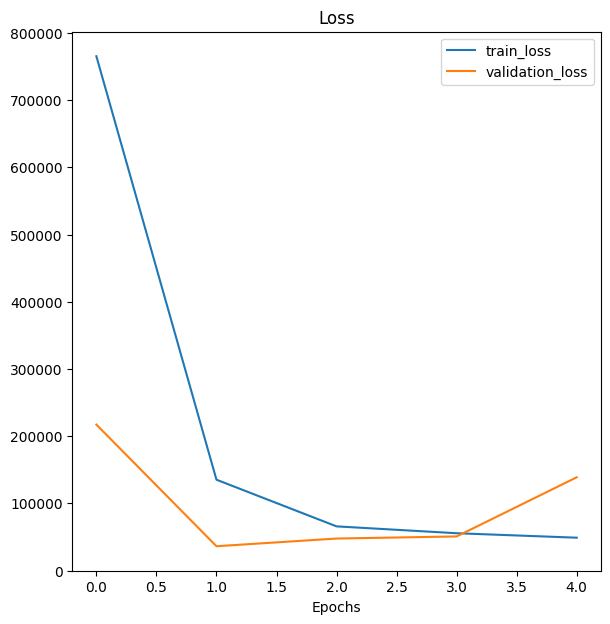

In [131]:
from typing import List, Dict

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "test_loss": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    val_loss = results['validation_loss']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    return plt

plot_loss_curves(model_results)